<a href="https://www.kaggle.com/code/kyleokeefe/identifying-fake-accounts?scriptVersionId=121485095" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kaggle-bot-account-detection/kaggle_bot_accounts.csv


# Creating a Neural Network to Identify Bots
Bots are a problem for every platform. They help influence outcomes and skew data. My goal with this notebook is to use Keras to train a model to be able to identify if a user is real or not.

## Importing Data

Step one is always importing the information and doing initial analysis.

In [2]:
df = pd.read_csv("/kaggle/input/kaggle-bot-account-detection/kaggle_bot_accounts.csv")
print(df.info())
print(df.isnull().sum())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321188 entries, 0 to 1321187
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1321188 non-null  int64  
 1   NAME                   1243024 non-null  object 
 2   GENDER                 1243309 non-null  object 
 3   EMAIL_ID               1243374 non-null  object 
 4   IS_GLOGIN              1243272 non-null  object 
 5   FOLLOWER_COUNT         1243476 non-null  float64
 6   FOLLOWING_COUNT        1242743 non-null  float64
 7   DATASET_COUNT          1242621 non-null  float64
 8   CODE_COUNT             1243262 non-null  float64
 9   DISCUSSION_COUNT       1243466 non-null  float64
 10  AVG_NB_READ_TIME_MIN   1242872 non-null  float64
 11  REGISTRATION_IPV4      1242859 non-null  object 
 12  REGISTRATION_LOCATION  1242898 non-null  object 
 13  TOTAL_VOTES_GAVE_NB    1243483 non-null  float64
 14  TOTAL_VOTES_GAVE_D

,Unnamed: 0,NAME,GENDER,EMAIL_ID,IS_GLOGIN,FOLLOWER_COUNT,FOLLOWING_COUNT,DATASET_COUNT,CODE_COUNT,DISCUSSION_COUNT,AVG_NB_READ_TIME_MIN,REGISTRATION_IPV4,REGISTRATION_LOCATION,TOTAL_VOTES_GAVE_NB,TOTAL_VOTES_GAVE_DS,TOTAL_VOTES_GAVE_DC,ISBOT
0,0,Johnny KerrThomas,Male,jacksonalan@example.com,False,53.0,87.0,5.0,3.0,124.0,NaN,81.88.75.170,Argentina,16.0,10.0,3.0,NaN
1,1,Dwayne LarsenLara,Male,calvin80@example.com,True,16.0,67.0,5.0,NaN,26.0,24.97,NaN,New Zealand,14.0,5.0,2.0,NaN
2,2,NaN,Male,qbrown@example.net,True,44.0,81.0,4.0,17.0,125.0,7.75,159.202.103.178,Costa Rica,16.0,4.0,0.0,False
3,3,Russell SimmonsPhillips,Male,kimberlywagner@example.com,True,23.0,114.0,5.0,24.0,67.0,13.40,196.11.132.51,Italy,21.0,10.0,1.0,False
4,4,Jamie WilsonMartinez,Female,shaunbrooks@example.com,False,46.0,112.0,2.0,12.0,63.0,24.83,159.196.199.20,Belgium,10.0,6.0,2.0,False


## Initial Reaction

There are a lot of null values in this dataset. I am not planning on using all of these columns for my neural network and therefore believe that dropping those columns will reduce the total number of null values. Because my dataset is so large, I was going to drop whatever columns are null and I hope this will help stop the removal of otherwise useful data.

## Exploring the Data
There is a lot of data and datapoint in this dataset so let's look further and see if we can see any initial patterns before feeding it into or neural network

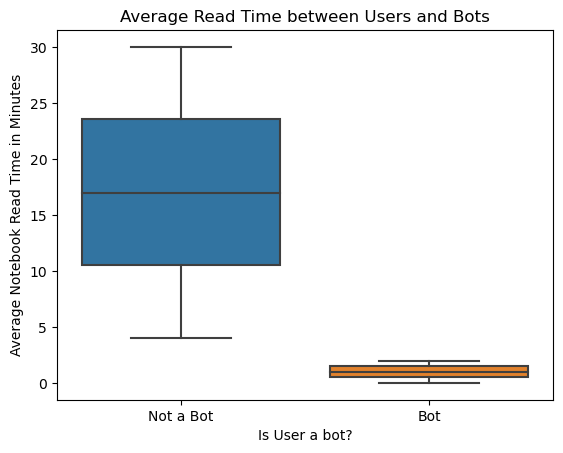

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='ISBOT', y='AVG_NB_READ_TIME_MIN', data=df)
#plt.yticks(range(0, round(df.AVG_NB_READ_TIME_MIN.max()+1)))
plt.ylabel("Average Notebook Read Time in Minutes")
plt.xticks([0, 1], labels=["Not a Bot", "Bot"])
plt.xlabel("Is User a bot?")
plt.title("Average Read Time between Users and Bots")
plt.show()

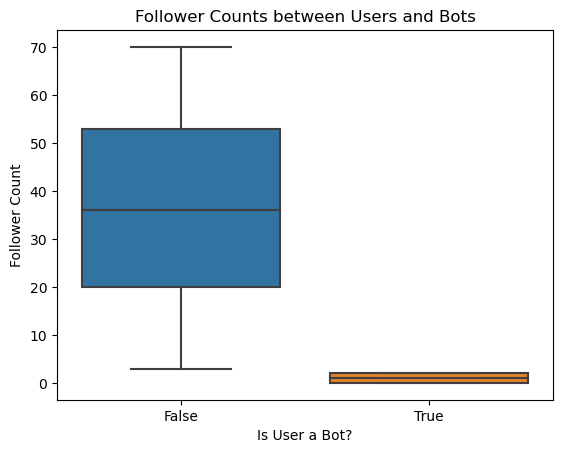

In [4]:
sns.boxplot(x="ISBOT", y="FOLLOWER_COUNT", data=df)
plt.title("Follower Counts between Users and Bots")
plt.ylabel("Follower Count")
plt.xlabel("Is User a Bot?")
plt.show()

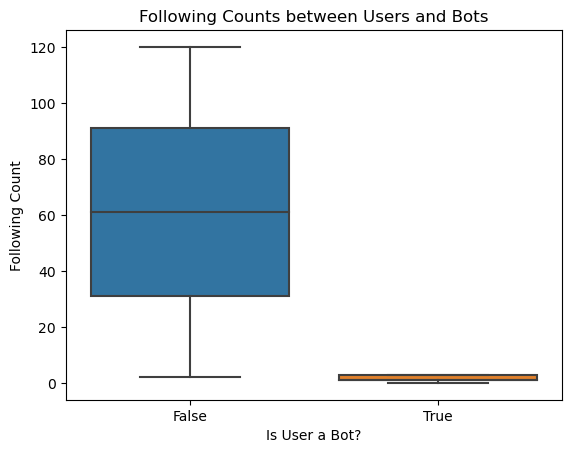

In [5]:
sns.boxplot(x="ISBOT", y="FOLLOWING_COUNT", data=df)
plt.title("Following Counts between Users and Bots")
plt.ylabel("Following Count")
plt.xlabel("Is User a Bot?")
plt.show()

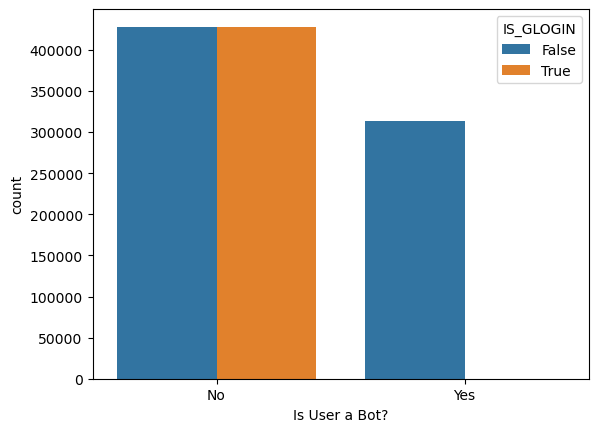

In [6]:
sns.countplot(hue = "IS_GLOGIN", x='ISBOT', data=df)
plt.xlabel("Is User a Bot?")
plt.xticks([0, 1], ["No", "Yes"])
plt.show()

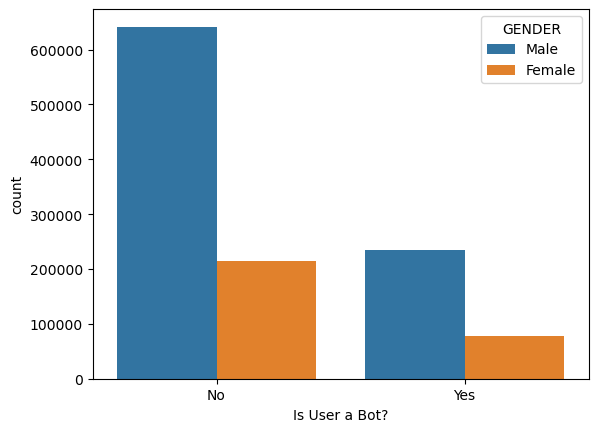

In [7]:
sns.countplot(x='ISBOT', hue='GENDER', data=df)
plt.xlabel("Is User a Bot?")
plt.xticks([0, 1], ["No", "Yes"])
plt.show()

In [8]:
#Getting numeric values for writeup
print(df[df.ISBOT == True]['AVG_NB_READ_TIME_MIN'].max())
print(df[df.ISBOT == True]['FOLLOWER_COUNT'].max())
print(df[df.ISBOT == True]['FOLLOWING_COUNT'].max())

1.99
2.0
3.0


## Reaction to Visualization

Let's take this plot by plot. 

### Average Reading Time
In our first boxplot, we see that average reading time for bots is at the most just undet two minutes. For most explanations of large datasets, two minutes is not enough time to read through all the information. 

### Follwer and Following Count
The follower and following counts also flagged for bots. While there are users with low numbers of followers and following, no bots have large numbers of followers or following. 

### Google Login
The next thing I looked into was whether or not a user used Google login. Based on the countplot, bots never use Google to login. Whether or not a person logs in with Google isn't indicadive if they're a bot or not, but if a person uses Google to login, we know they're not a bot

### Gender
I explored gender next to see if bots were a specific gender over another and found that rates between male and female were similar between bots and users.

## Editing features of the dataframe
The columns "unnamed" (a redundant column), gender, name, email_id, registration_ipv4, registration_location I find are not going to be useful for my machine learning model so I am going to drop those. noncategorical data like their name, email, and ipv4 are not useful for my model, while categorical values like gender and registration location appear at the same rate for bots vs nonbots so their inculusion doesn't help our model.

In [9]:
df = df.drop(columns = ['Unnamed: 0', 'NAME', 'GENDER', 'EMAIL_ID', 'REGISTRATION_IPV4', 'REGISTRATION_LOCATION'])
df = df.dropna()
df

,IS_GLOGIN,FOLLOWER_COUNT,FOLLOWING_COUNT,DATASET_COUNT,CODE_COUNT,DISCUSSION_COUNT,AVG_NB_READ_TIME_MIN,TOTAL_VOTES_GAVE_NB,TOTAL_VOTES_GAVE_DS,TOTAL_VOTES_GAVE_DC,ISBOT
2,True,44.0,81.0,4.0,17.0,125.0,7.75,16.0,4.0,0.0,False
3,True,23.0,114.0,5.0,24.0,67.0,13.40,21.0,10.0,1.0,False
4,False,46.0,112.0,2.0,12.0,63.0,24.83,10.0,6.0,2.0,False
5,False,2.0,2.0,0.0,0.0,0.0,0.62,18.0,9.0,2.0,True
7,False,2.0,1.0,0.0,0.0,6.0,1.85,21.0,3.0,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...
1321177,False,2.0,3.0,0.0,1.0,3.0,0.80,23.0,9.0,3.0,True
1321178,False,37.0,63.0,3.0,18.0,61.0,27.29,25.0,9.0,3.0,False
1321180,False,12.0,120.0,4.0,5.0,124.0,16.89,23.0,6.0,2.0,False
1321184,True,20.0,60.0,6.0,14.0,44.0,23.39,22.0,10.0,3.0,False


In [10]:
# Converting Boolean values to binary
df['IS_GLOGIN'] = df['IS_GLOGIN'].astype(int)
df['ISBOT'] = df['ISBOT'].astype(int)
# Converting gender to dummy
df = pd.get_dummies(df)
df.reset_index(drop=True)

,IS_GLOGIN,FOLLOWER_COUNT,FOLLOWING_COUNT,DATASET_COUNT,CODE_COUNT,DISCUSSION_COUNT,AVG_NB_READ_TIME_MIN,TOTAL_VOTES_GAVE_NB,TOTAL_VOTES_GAVE_DS,TOTAL_VOTES_GAVE_DC,ISBOT
0,1,44.0,81.0,4.0,17.0,125.0,7.75,16.0,4.0,0.0,0
1,1,23.0,114.0,5.0,24.0,67.0,13.40,21.0,10.0,1.0,0
2,0,46.0,112.0,2.0,12.0,63.0,24.83,10.0,6.0,2.0,0
3,0,2.0,2.0,0.0,0.0,0.0,0.62,18.0,9.0,2.0,1
4,0,2.0,1.0,0.0,0.0,6.0,1.85,21.0,3.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
676555,0,2.0,3.0,0.0,1.0,3.0,0.80,23.0,9.0,3.0,1
676556,0,37.0,63.0,3.0,18.0,61.0,27.29,25.0,9.0,3.0,0
676557,0,12.0,120.0,4.0,5.0,124.0,16.89,23.0,6.0,2.0,0
676558,1,20.0,60.0,6.0,14.0,44.0,23.39,22.0,10.0,3.0,0


## Building the neural network
At this point, our data is ready to be fed into a machine learning algorithm. I am deciding to do a neural network due to its ability to optimize itself. We need to create our X, our y, build the NN, train it, and predict off the test data.

In [11]:
# Creating X and y
y = df['ISBOT']
X = df.drop(columns = 'ISBOT')
print(X) ; print(y); print(X.shape)

         IS_GLOGIN  FOLLOWER_COUNT  FOLLOWING_COUNT  DATASET_COUNT  \
2                1            44.0             81.0            4.0   
3                1            23.0            114.0            5.0   
4                0            46.0            112.0            2.0   
5                0             2.0              2.0            0.0   
7                0             2.0              1.0            0.0   
...            ...             ...              ...            ...   
1321177          0             2.0              3.0            0.0   
1321178          0            37.0             63.0            3.0   
1321180          0            12.0            120.0            4.0   
1321184          1            20.0             60.0            6.0   
1321185          1            20.0             64.0            3.0   

         CODE_COUNT  DISCUSSION_COUNT  AVG_NB_READ_TIME_MIN  \
2              17.0             125.0                  7.75   
3              24.0              

In [12]:
# Importing necessary packages
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(y_train.shape[1], X_train.shape)

2 (507420, 10)


In [14]:
#Define model
model = Sequential()
model.add(Dense(25, activation='relu', input_dim=10))
model.add(Dense(12, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(2, activation ='sigmoid'))

#compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#build model
model.fit(X_train, y_train, epochs=5, batch_size=500)

Epoch 1/5
1015/1015 [==============================] - 4s 3ms/step - loss: 0.0549 - accuracy: 0.9959
Epoch 2/5
1015/1015 [==============================] - 3s 3ms/step - loss: 1.2030e-04 - accuracy: 1.0000
Epoch 3/5
1015/1015 [==============================] - 3s 3ms/step - loss: 4.8304e-05 - accuracy: 1.0000
Epoch 4/5
1015/1015 [==============================] - 3s 3ms/step - loss: 2.8220e-05 - accuracy: 1.0000
Epoch 5/5
1015/1015 [==============================] - 3s 3ms/step - loss: 1.0746e-05 - accuracy: 1.0000


In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=100)
print('Test accuaracy:', round(test_acc, 2))

1692/1692 [==============================] - 4s 2ms/step - loss: 5.3151e-06 - accuracy: 1.0000
Test accuaracy: 1.0


## Conclusion

The Keras neural network I have created has been able to predict with 100% accuracy whether or not an account is a bot. Obviously, I am not going to claim it is 100% accurate 100% of the time, but it obviously shows its merit. As we saw with the data analysis, bots have very obvious patterns of behavior so it was very easy to train a neural network.